In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d tushar5harma/plant-village-dataset-updated

100% 1.00G/1.00G [00:17<00:00, 94.5MB/s]
100% 1.00G/1.00G [00:17<00:00, 60.6MB/s]


In [ ]:
!unzip /content/plant-village-dataset-updated.zip

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense , Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from tensorflow.keras.models import load_model
import itertools
import os
import glob as gb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [4]:
batch_size = 32
num_epochs = 10
num_classes = 4

In [10]:
train_path = '/content/Apple/Train'
test_path = '/content/Apple/Test'
val_path = '/content/Apple/Val'


Image_Gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

Val_Gen = ImageDataGenerator(
    rescale = 1.0 / 255.0
)


train_generator = Image_Gen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
)


validation_generator = Val_Gen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
)

test_generator = Val_Gen.flow_from_directory(
    test_path ,
    target_size = (224, 224) ,
    class_mode = 'categorical',
)


Found 7771 images belonging to 4 classes.
Found 1746 images belonging to 4 classes.
Found 196 images belonging to 4 classes.


In [21]:
class_names = list(train_generator.class_indices.keys())
class_names

['Apple Scab', 'Black Rot', 'Cedar Apple Rust', 'Healthy']

In [22]:
map = {value:key for key,value in train_generator.class_indices.items()}
map

{0: 'Apple Scab', 1: 'Black Rot', 2: 'Cedar Apple Rust', 3: 'Healthy'}

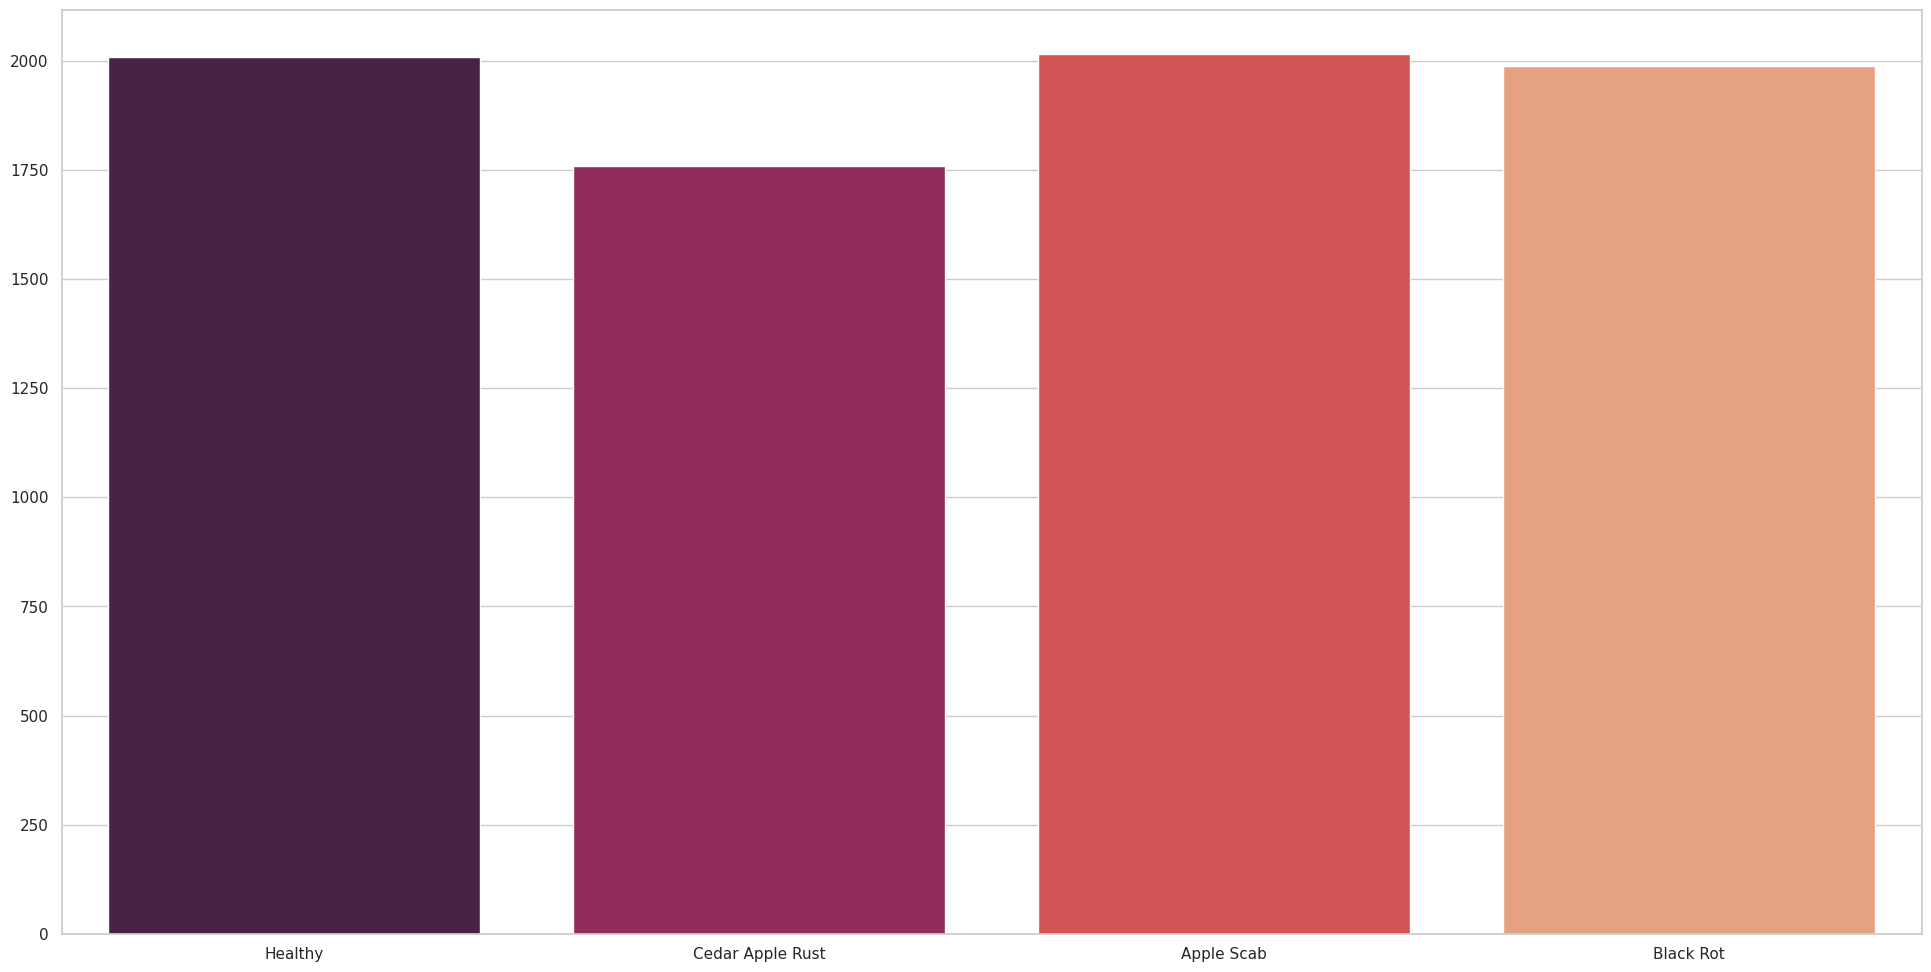

In [8]:
import os
import glob as gb
sns.set_theme(style="whitegrid")
Data_imbalance = []
x_ax = []
for folder in os.listdir(train_path):
    files = gb.glob(pathname=str(train_path + "/" + folder +"/*.*"))
    Data_imbalance.append(len(files))
    x_ax.append(folder)
plt.figure(figsize=(24,12))
sns.barplot(x=x_ax, y=Data_imbalance, palette="rocket")
plt.show()

In [10]:
total = 0
for i in range(0, len(Data_imbalance)):
    total += Data_imbalance[i]

class_weights = {}
for i in range(len(Data_imbalance)):
    weight_for_class = (1 / Data_imbalance[i]) * (total / 4.0)
    class_weights[i] = weight_for_class
    print('Weight for class {}: {:.2f}'.format(i, weight_for_class))

print(class_weights)

Weight for class 0: 0.97
Weight for class 1: 1.10
Weight for class 2: 0.96
Weight for class 3: 0.98
{0: 0.9675049800796812, 1: 1.1038352272727272, 2: 0.9636656746031745, 3: 0.977730246602919}


In [11]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

# Add custom layers for fine-tuning
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)  # Replace 'num_classes' with the number of classes in your dataset

# Create the final model for fine-tuning
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

9406464/9406464 [==============================] - 0s 0us/step


In [12]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,
    validation_data=validation_generator,
    validation_steps=len(validation_generator) ,
    class_weight = class_weights ,
    callbacks = [early_stopping]
)

Epoch 1/15
243/243 [==============================] - 156s 471ms/step - loss: 0.2621 - accuracy: 0.9032 - val_loss: 0.5078 - val_accuracy: 0.8351
Epoch 2/15
243/243 [==============================] - 114s 469ms/step - loss: 0.0404 - accuracy: 0.9861 - val_loss: 0.3956 - val_accuracy: 0.8821
Epoch 3/15
243/243 [==============================] - 114s 468ms/step - loss: 0.0191 - accuracy: 0.9947 - val_loss: 0.5194 - val_accuracy: 0.8661
Epoch 4/15
243/243 [==============================] - 114s 469ms/step - loss: 0.0214 - accuracy: 0.9937 - val_loss: 0.3218 - val_accuracy: 0.9061
Epoch 5/15
243/243 [==============================] - 114s 471ms/step - loss: 0.0158 - accuracy: 0.9943 - val_loss: 0.4294 - val_accuracy: 0.8998
Epoch 6/15
243/243 [==============================] - 114s 468ms/step - loss: 0.0121 - accuracy: 0.9960 - val_loss: 0.0532 - val_accuracy: 0.9817
Epoch 7/15
243/243 [==============================] - 114s 470ms/step - loss: 0.0157 - accuracy: 0.9952 - val_loss: 0.0409 -

In [14]:
!mkdir /content/drive/MyDrive/SIH-Models/Apple
model.save('/content/drive/MyDrive/SIH-Models/Apple/apple_mobilenetv2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Plots saved as '/content/drive/MyDrive/SIH-Models/Apple/train and loss'


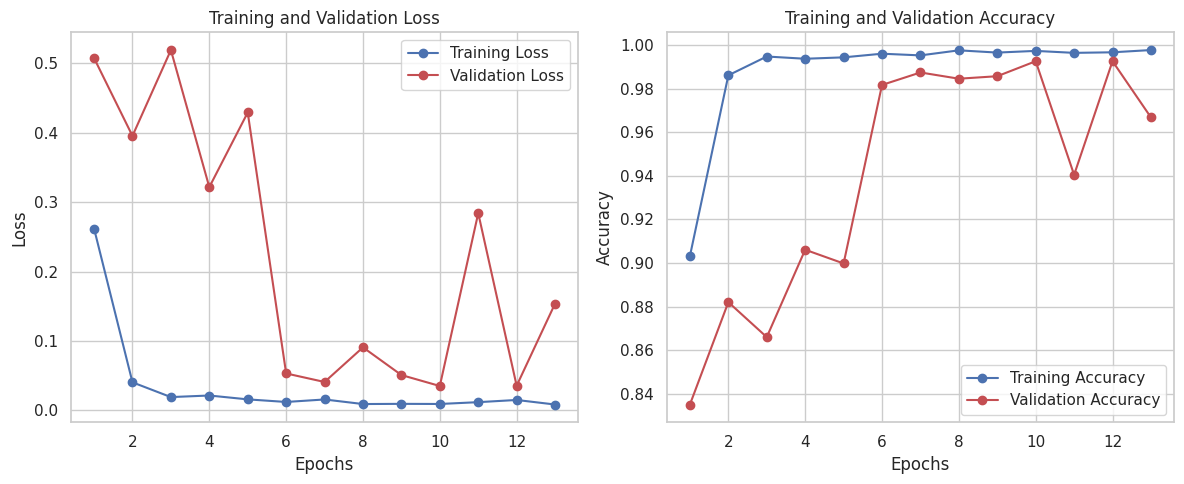

In [15]:
def plot_loss_and_accuracy(history, save_dir=None, filename=None):
    # Extract the loss and accuracy values from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Get the number of epochs
    epochs = range(1, len(loss) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    # Save the figure if save_dir and filename are provided
    if save_dir and filename:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, filename)
        plt.savefig(save_path)
        print(f"Plots saved as '{save_path}'")

    plt.show()
plot_loss_and_accuracy(history ,"/content/drive/MyDrive/SIH-Models/Apple", "train and loss" )



In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for i in range(len(validation_generator)):
    true_labels = validation_generator[i][1]
    y_true.extend(true_labels)

    preds = model.predict(validation_generator[i][0])

    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true = np.argmax(y_true , axis = 1)

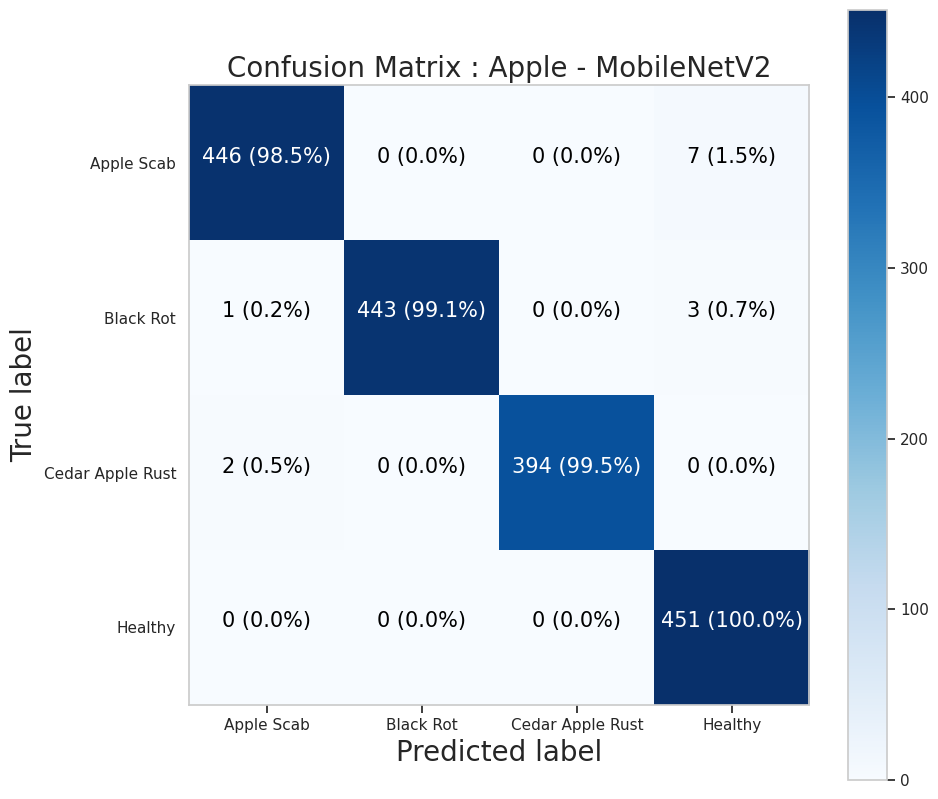

In [26]:
import itertools
from sklearn.metrics import confusion_matrix

figsize = (10, 10)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred )
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
n_classes = cm.shape[0]

# Let's prettify it
fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

# Create classes
classes = True

if classes:
  labels = class_names
else:
  labels = np.arange(cm.shape[0])

# Label the axes
ax.set(title="Confusion Matrix : Apple - MobileNetV2",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)
threshold = (cm.max() + cm.min()) / 2.

plt.grid(False)

# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
           horizontalalignment="center",
           color="white" if cm[i, j] > threshold else "black",
           size=15)
plt.savefig('/content/drive/MyDrive/SIH-Models/Apple/Model-CM')


In [18]:
print(classification_report(y_true , y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       453
           1       1.00      0.99      1.00       447
           2       1.00      0.99      1.00       396
           3       0.98      1.00      0.99       451

    accuracy                           0.99      1747
   macro avg       0.99      0.99      0.99      1747
weighted avg       0.99      0.99      0.99      1747



## 2) FLOAT16 Qauntized

In [19]:
model = load_model('/content/drive/MyDrive/SIH-Models/Apple/apple_mobilenetv2.h5')

In [20]:
# Convert the Keras model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('/content/drive/MyDrive/SIH-Models/Apple/apple_mobilenetv2.tflite', 'wb') as f:
    f.write(tflite_model)

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/SIH-Models/Apple/apple_mobilenetv2.tflite')
interpreter.allocate_tensors()

# Quantization using float16
converter_float16 = tf.lite.TFLiteConverter.from_keras_model(model)
converter_float16.optimizations = [tf.lite.Optimize.DEFAULT]
converter_float16.target_spec.supported_types = [tf.float16]
tflite_model_float16 = converter_float16.convert()

# Save the float16 quantized TFLite model
with open('/content/drive/MyDrive/SIH-Models/Apple/apple_mobilenetv2_float16.tflite', 'wb') as f:
    f.write(tflite_model_float16)

In [21]:
TF_LITE_MODEL_FILE_NAME = "/content/drive/MyDrive/SIH-Models/Apple/apple_mobilenetv2_float16.tflite"

In [22]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 4]
Output Type: <class 'numpy.float32'>


In [37]:
1746 / 2

873.0

In [13]:
import numpy as np

# Initialize lists to store test images and labels
test_imgs = []
test_labels = []

# Loop through the test generator to collect images and labels
for _ in range(len(validation_generator)):
    batch = validation_generator.next()  # Get the next batch from the iterator
    batch_images, batch_labels = batch  # Extract images and labels from the batch

    # Append the batch of images and labels to the respective lists
    test_imgs.extend(batch_images)
    test_labels.extend(batch_labels)

# Convert the lists to NumPy arrays
test_imgs = np.array(test_imgs)
test_labels = np.array(test_labels)

In [38]:
interpreter.resize_tensor_input(input_details[0]['index'], (873, 224,224,3 ))
interpreter.resize_tensor_input(output_details[0]['index'], (873, 4))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [873 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [873   4]
Output Type: <class 'numpy.float32'>


In [41]:
tflite_model_predictions = np.empty((len(test_imgs), 4))  # Initialize with the correct shape

for start in range(0, len(test_imgs), 873):
    test_batch = test_imgs[start: start + 873]
    interpreter.set_tensor(input_details[0]['index'], test_batch)
    interpreter.invoke()
    tflite_model_pred = interpreter.get_tensor(output_details[0]['index'])
    tflite_model_predictions[start: start + 873] = tflite_model_pred  # Assign predictions to the corresponding batch

print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (1746, 4)


In [42]:
print(classification_report(np.argmax(test_labels , axis=1) , prediction_classes))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       453
           1       1.00      0.99      0.99       447
           2       1.00      0.99      1.00       396
           3       0.97      1.00      0.99       450

    accuracy                           0.99      1746
   macro avg       0.99      0.99      0.99      1746
weighted avg       0.99      0.99      0.99      1746



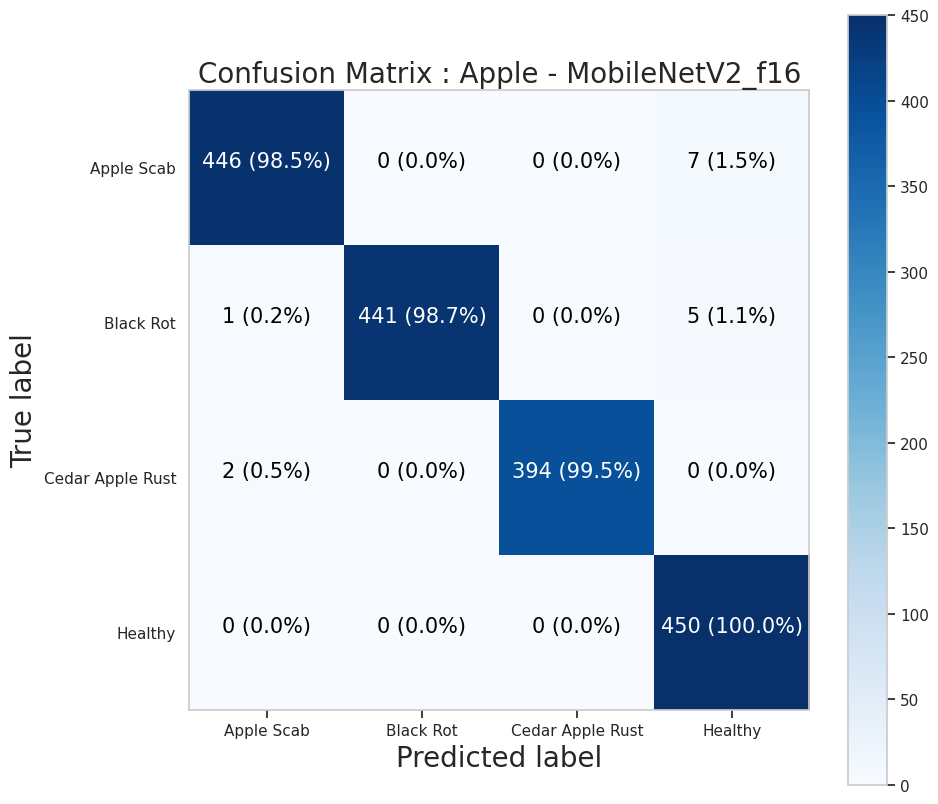

In [43]:
figsize = (10 , 10)

# Create the confusion matrix
cm = confusion_matrix(np.argmax(test_labels , axis=1) , prediction_classes)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
n_classes = cm.shape[0]

# Let's prettify it
fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

# Create classes
classes = True

if classes:
  labels = class_names
else:
  labels = np.arange(cm.shape[0])

# Label the axes
ax.set(title="Confusion Matrix : Apple - MobileNetV2_f16",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)
plt.grid(False)
threshold = (cm.max() + cm.min()) / 2.

# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
           horizontalalignment="center",
           color="white" if cm[i, j] > threshold else "black",
           size=15)
plt.savefig('/content/drive/MyDrive/SIH-Models/Apple/Modelfloat16-CM')

## 3) INT8 Qauntized Model

In [6]:
# Load your trained Keras model in .h5 format
keras_model = load_model("/content/drive/MyDrive/SIH-Models/Apple/apple_mobilenetv2.h5")  # Replace with your model path

# Create the TFLite converter
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.int8]


generator =  Val_Gen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
)

num_calibration_steps = 20
def representative_data_gen():
    for batch_idx in range(num_calibration_steps):
        batch = generator.next()  # Get the next batch
        yield [batch[0]]  # Yield the batch inputs

# Set the representative dataset using the generator function
converter.representative_dataset = representative_data_gen

# Convert the model to quantized TFLite format
tflite_model_quantized = converter.convert()

# Save the quantized TFLite model
with open('/content/drive/MyDrive/SIH-Models/Apple/apple_mobilenetv2_int8.tflite', 'wb') as f:
    f.write(tflite_model_quantized)

Found 1747 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [7]:
TF_LITE_MODEL_FILE_NAME = "/content/drive/MyDrive/SIH-Models/Apple/apple_mobilenetv2_int8.tflite"

In [16]:

interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 4]
Output Type: <class 'numpy.float32'>


In [15]:
print(test_imgs.shape)
test_labels.shape

(1746, 224, 224, 3)


(1746, 4)

In [17]:

interpreter.resize_tensor_input(input_details[0]['index'], (873, 224,224,3 ))
interpreter.resize_tensor_input(output_details[0]['index'], (873, 4))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [873 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [873   4]
Output Type: <class 'numpy.float32'>


In [18]:
tflite_model_predictions = np.empty((len(test_imgs), 4))  # Initialize with the correct shape

for start in range(0, len(test_imgs), 873):
    test_batch = test_imgs[start: start + 873]
    interpreter.set_tensor(input_details[0]['index'], test_batch)
    interpreter.invoke()
    tflite_model_pred = interpreter.get_tensor(output_details[0]['index'])
    tflite_model_predictions[start: start + 873] = tflite_model_pred  # Assign predictions to the corresponding batch

print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (1746, 4)


In [19]:
print(classification_report(np.argmax(test_labels , axis=1) , prediction_classes))


              precision    recall  f1-score   support

           0       0.97      0.98      0.98       453
           1       1.00      0.90      0.95       447
           2       0.99      1.00      0.99       396
           3       0.92      1.00      0.96       450

    accuracy                           0.97      1746
   macro avg       0.97      0.97      0.97      1746
weighted avg       0.97      0.97      0.97      1746



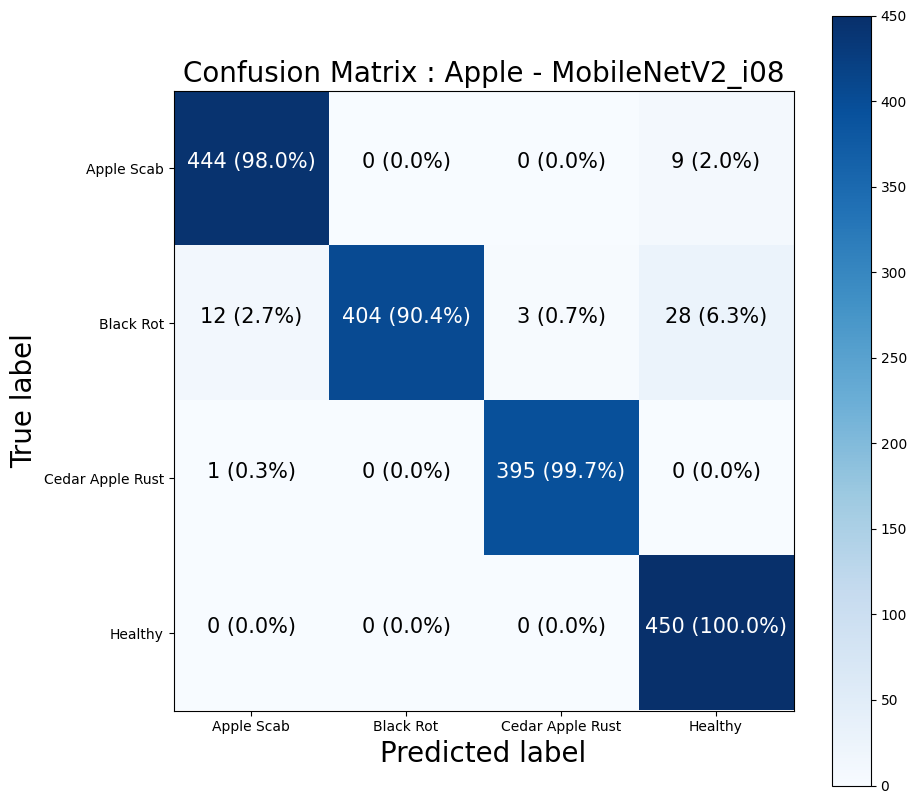

In [23]:
figsize = (10 , 10)

# Create the confusion matrix
cm = confusion_matrix(np.argmax(test_labels , axis=1) , prediction_classes)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
n_classes = cm.shape[0]

# Let's prettify it
fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

# Create classes
classes = True

if classes:
  labels = class_names
else:
  labels = np.arange(cm.shape[0])

# Label the axes
ax.set(title="Confusion Matrix : Apple - MobileNetV2_i08",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)
plt.grid(False)
threshold = (cm.max() + cm.min()) / 2.

# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
           horizontalalignment="center",
           color="white" if cm[i, j] > threshold else "black",
           size=15)
plt.savefig('/content/drive/MyDrive/SIH-Models/Apple/ModelInt8-CM')



---